In [5]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')



%store -r WORKDIR

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/BZ241WX/Documents/InfNet/CursoPosDataScience/mit_data_science/'


data_proc_file = WORKDIR + '/Data/Processed/covid19_data_modeling.parquet'


pd.plotting.register_matplotlib_converters()

# Leitura dos Dados 

In [6]:
df = pd.read_parquet(data_proc_file)

print('shape:', df.shape)
print('columns:', df.columns)

shape: (27532, 5)
columns: Index(['cases', 'countrycode', 'date', 'deaths', 'recovered'], dtype='object')


# Distribuição dos Top Países em Casos da Doença

Text(0.5, 0, '')

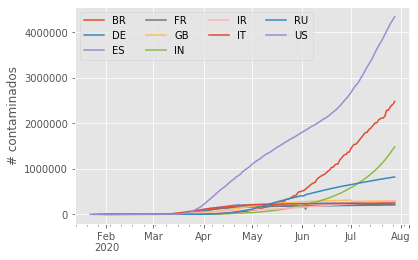

In [9]:
nshow=10
X = df.groupby('countrycode').cases.sum().sort_values()
countries = X.iloc[-nshow:].index.tolist()
df[df.countrycode.isin(countries)].pivot_table(index='date',columns='countrycode',values='cases',aggfunc='sum').plot()
plt.legend(ncol=4)
plt.ylabel('# contaminados')
plt.xlabel('')

# Paises com Mais Contaminados 

Text(0, 0.5, 'Código do País')

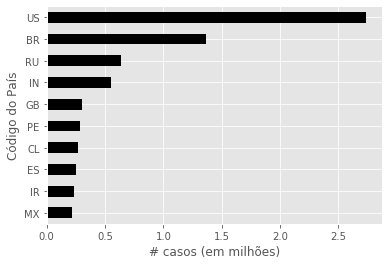

In [11]:
nshow = 10
plt.figure(figsize=(6,4))
X = df.groupby('countrycode').cases.last().sort_values() * 1e-6
X.iloc[-nshow:].plot.barh(color='k')
plt.xlabel('# casos (em milhões)')
plt.ylabel('Código do País')